In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statistics as stat
import time
import scipy
import scipy.stats
import pymc3 as pm

In [31]:
# Read in CSV files
df_all = pd.read_csv('all_RVs.csv').drop(['Unnamed: 0'], axis=1)

In [32]:
df_all

,Target ID,Plate ID,MJD,OBSVHELIO (km/s),OBSVREL Error (km/s),<RV>,ΔRV
0,apo1m.1.Bestars.,Bestars,58017,-523.166440,0.234950,-525.619404,2.452961
1,apo1m.1.Bestars.,Bestars,58022,-526.084350,0.102290,-525.619404,-0.464947
2,apo1m.1.calibration.VESTA,calibration,56398,25.553330,0.018306,14.014931,11.538398
3,apo1m.1.calibration.VESTA,calibration,56778,10.561789,0.010014,14.014931,-3.453142
4,apo1m.1.calibration.,calibration,57743,-36.204376,0.003971,-36.204376,0.000000
...,...,...,...,...,...,...,...
1730343,apo25m.4424.116-04.2M23595886+5726058,5583,56261,-60.935745,0.012662,-60.924493,-0.011252
1730344,apo25m.4424.116-04.2M23595886+5726058,5583,56284,-60.901040,0.019322,-60.924493,0.023454
1730345,apo25m.4548.105-45.2M23595980+1528407,6560,56584,-5.201384,0.050281,-5.175535,-0.025849
1730346,apo25m.4548.105-45.2M23595980+1528407,6560,56588,-5.034553,0.066701,-5.175535,0.140983


In [33]:
df_wavg = pd.read_csv('weightedavg_RVs.csv').drop(['Unnamed: 0'], axis=1)

In [34]:
df_wavg

,MJD,Combined ΔRV (m/s),Combined σRV (m/s),std
0,58022.0,-8.053015,0.407374,0.320451
1,57743.0,0.023227,2.212728,0.027177
2,56933.0,9.254238,0.147462,0.192564
3,56936.0,23.920864,0.095845,0.257771
4,56971.0,-178.377692,0.062524,0.258691
...,...,...,...,...
1519,55870.0,-73.029691,0.946294,0.348151
1520,56617.0,62.421917,1.511150,0.432546
1521,56625.0,11.459281,0.557512,0.309172
1522,56576.0,58.248624,0.569609,0.247437


In [42]:
muall = np.mean(list(df_all['ΔRV']))
muavg = np.mean(list(df_wavg['Combined ΔRV (m/s)']))

In [43]:
muall

-0.04689815928958173

In [45]:
stdall = np.array(list(df_all['ΔRV'])).std()
stdavg = np.array(list(df_wavg['Combined ΔRV (m/s)'])).std()

In [46]:
stdall

21.14692459505227

## MCMC Plan

### Steps
1. Run a markov chain on fitting slope (30 days, 7 days, 28 days)
2. Bootstrap error terms
3. Fit for 2 parameters of line + additional error term, do with 1wk binning and 30d binning; will determine if posteriors on slopes are consistent

### Working?
- b = ?, x = ?
- sigma = ?
- each point is probs a Gaussian

In [58]:
# 30 day binning
n = 81
_b = -1.847834726942623
_a = 0.1040542656085063
_sigma = 20.10334754313373
x = np.linspace(0, 80, 81)
y = _a*x + _b

## Attempt 1

In [54]:
niter = 10000
with pm.Model() as linreg:
    a = pm.Normal('a', mu=0, sd=100)
    b = pm.Normal('b', mu=0, sd=100)
    sigma = pm.HalfNormal('sigma', sd=1)

    y_est = a*x + b
    likelihood = pm.Normal('y', mu=y_est, sd=sigma, observed=y)

    start = pm.find_MAP()
    step = pm.NUTS(scaling=start)
    trace = pm.sample(niter, step, start, random_seed=123)

/var/folders/hh/025gcjhx0zx_78ws1t9nf3f80000gn/T/ipykernel_2382/1577628452.py:12: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(niter, step, start, random_seed=123)
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, b, a]


Sampling 4 chains for 1_000 tune and 10_000 draw iterations (4_000 + 40_000 draws total) took 1255 seconds.
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
There were 36 divergences after tuning. Increase `target_accept` or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The chain reached the maximum tree depth. Increase max_treedepth, increase target_accept or reparameterize.
The rhat statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


/var/folders/hh/025gcjhx0zx_78ws1t9nf3f80000gn/T/ipykernel_2382/1702142005.py:2: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  pm.traceplot(trace, var_names=['a', 'b'])
/opt/anaconda3/lib/python3.9/site-packages/arviz/data/io_pymc3.py:96: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  warnings.warn(


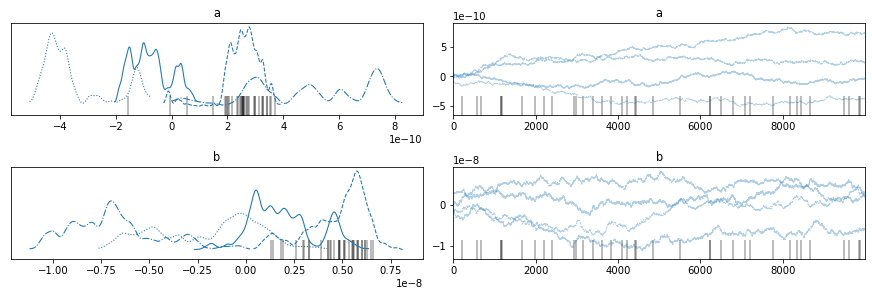

In [56]:
t = trace[niter//2:]
pm.traceplot(trace, var_names=['a', 'b'])
pass

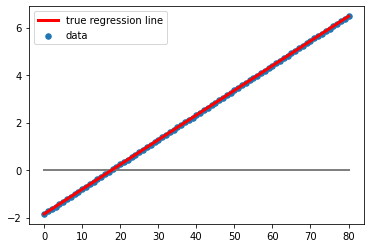

In [57]:
plt.scatter(x, y, s=30, label='data')
for a_, b_ in zip(t['a'][-100:], t['b'][-100:]):
    plt.plot(x, a_*x + b_, c='gray', alpha=0.1)
plt.plot(x, _a*x + _b, label='true regression line', lw=3., c='red')
plt.legend(loc='best')
pass

In [47]:
N = 1524

In [48]:
np.random?

In [49]:
rand = np.random.normal(size=N)
seed = np.random.seed(1)
print(rand)

[-0.21016298 -0.00283532  0.75110877 ... -0.31113498  0.3469913
  1.54344288]


In [50]:
mu = muavg
sigma = stdavg

In [51]:
M = pm.Normal('M', mu, sigma, observed=True, value=x)
model = dict(M=M, mu=mu)

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.

In [ ]:
# initial belief
sigma_e = 3.0            # make it known to avoid inverse gamma complexity
a_0 = 0.5
b_0 = 0.5
sigma_a_0 = 0.5
sigma_b_0 = 0.5
beta_0 = np.array([[a_0], [b_0]])
sigma_beta_0 = np.array([[sigma_a_0*sigma_a_0, 0], [0, sigma_b_0*sigma_b_0]])

beta_recorder = []           # record parameter beta
beta_recorder.append(beta_0)
for pair in range(250):       # 500 points means 250 pairs
    x1 = x[pair*2]
    x2 = x[pair*2+1]
    y1 = y[pair*2]
    y2 = y[pair*2+1]
    mu_y = np.array([[(x1*y2-x2*y1)/(x1-x2)], [(y1-y2)/(x1-x2)]])
    sigma_y = np.array([[(np.square(x1/(x1-x2))+np.square(x2/(x1-x2)))*np.square(sigma_e),0],
                             [0,2*np.square(sigma_e/(x1-x2))]])
    sigma_beta_1 = np.linalg.inv(np.linalg.inv(sigma_beta_0)+np.linalg.inv(sigma_y))
    beta_1 = sigma_beta_1.dot(np.linalg.inv(sigma_beta_0).dot(beta_0) + np.linalg.inv(sigma_y).dot(mu_y))

    # assign beta_1 to beta_0
    beta_0 = beta_1
    sigma_beta_0 = sigma_beta_1
    beta_recorder.append(beta_0)

print('pamameters: %.7f, %.7f' %(beta_0[0], beta_0[1]))

# plot the Beyesian dynamics
xfit = np.linspace(0, 10, sample_size)
ytrue = 2.0 * xfit + 1.0       # we know the true value of slope and intercept
plt.plot(xfit, ytrue, label='true line', linewidth=3)
y0 = beta_recorder[0][1] * xfit + beta_recorder[0][0]
plt.plot(xfit, y0, label='initial belief', linewidth=1)
y1 = beta_recorder[1][1] * xfit + beta_recorder[1][0]
plt.plot(xfit, y1, label='1st update', linewidth=1)
y10 = beta_recorder[10][1] * xfit + beta_recorder[10][0]
plt.plot(xfit, y10, label='10th update', linewidth=1)
y100 = beta_recorder[100][1] * xfit + beta_recorder[100][0]
plt.plot(xfit, y100, label='100th update', linewidth=1)
plt.legend()

/var/folders/hh/025gcjhx0zx_78ws1t9nf3f80000gn/T/ipykernel_2382/3867102967.py:18: RuntimeWarning: invalid value encountered in log
  return np.log(a) + np.log(b)


[ 0.09777171 -1.86635383]


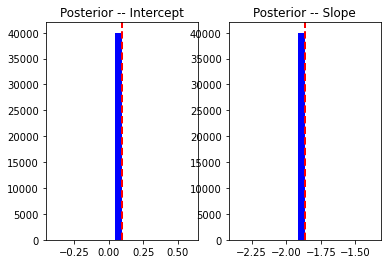

In [29]:
import scipy.stats
# don't forget to generate the 500 random samples as in the previous post
#tra = 0.09777171416860668
#trb = -1.8663538253776457
x = rand
#y = tra*x + trb + 
sigma_e = 3.0

# Similar to last post, let's initially believe that a, b follow Normal distribution 
# with mean 0.5 and standard deviation 0.5
# It returns the probability of seeing beta under this belief
def prior_probability(beta):
    a = beta[0]     # intercept
    b = beta[1]     # slope
    a_prior = scipy.stats.norm(0.5, 0.5).pdf(a)
    b_prior = scipy.stats.norm(0.5, 0.5).pdf(b)
    # log probability transforms multiplication to summation
    return np.log(a) + np.log(b)

# Given beta, the likehood of seeing x and y
def likelihood_probability(beta):
    a = beta[0]     # intercept
    b = beta[1]     # slope
    y_predict = a + b * x
    single_likelihoods = scipy.stats.norm(y_predict, sigma_e).pdf(y_predict) # .pdf(y) --> we know sigma_e is 3.0
    return np.sum(np.log(single_likelihoods))

# We don't need to know the denominator of support f(y)
# as it will be canceled out in the acceptance ratio
def posterior_probability(beta):
    return likelihood_probability(beta) + prior_probability(beta)

# jump from beta to new beta
# proposal function is Gaussian centered at beta
def proposal_function(beta):
    a = beta[0]
    b = beta[1]
    a_new = np.random.normal(a, 0.5)
    b_new = np.random.normal(b, 0.5)
    beta_new = [a_new, b_new]
    return beta_new

# run the Monte Carlo
beta_0 = [0.09777171416860668, -1.8663538253776457]        # start value
results = np.zeros([50000,2])            # record the results
results[0,0] = beta_0[0]
results[0, 1] = beta_0[1]
for step in range(1, 50000):               # loop 50,000 times
    #print('step: {}'.format(step))

    beta_old = results[step-1, :]
    beta_proposal = proposal_function(beta_old)

    # Use np.exp to restore from log numbers
    prob = np.exp(posterior_probability(beta_proposal) - posterior_probability(beta_old))

    if np.random.uniform(0,1) < prob:
        results[step, :] = beta_proposal    # jump
    else:
        results[step, :] = beta_old         # stay

burn_in = 10000
beta_posterior = results[burn_in:, :]
print(beta_posterior.mean(axis=0))        # use average as point estimates

# present the results
fig = plt.figure()
ax1 = fig.add_subplot(121)
ax1.hist(beta_posterior[:,0], bins=20, color='blue')
ax1.axvline(beta_posterior.mean(axis=0)[0], color='red', linestyle='dashed', linewidth=2)
ax1.title.set_text('Posterior -- Intercept')
ax2 = fig.add_subplot(122)
ax2.hist(beta_posterior[:,1], bins=20, color='blue')
ax2.axvline(beta_posterior.mean(axis=0)[1], color='red', linestyle='dashed', linewidth=2)
ax2.title.set_text('Posterior -- Slope')
plt.show()

In [23]:
N = len(df_wavg)
print('N =', N)

N = 1524


In [24]:
# Generate random Gaussian data w/ mu=0, sigma=1

x = np.random.normal(size=N)

In [26]:
# MCMC model w/ uniform prior on mu + fixed sigma 
mu = pm.Uniform('mu', -5, 5).dist
sigma = 1
M = pm.Normal('M', mu, sigma, observed=True, value=x)
model = dict(M=M, mu=mu)

TypeError: No model on context stack, which is needed to instantiate distributions. Add variable inside a 'with model:' block, or use the '.dist' syntax for a standalone distribution.